In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
import optuna
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

/Users/danielmilanesperez/anaconda3/envs/hoax-detection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("/Users/danielmilanesperez/Downloads/train_data.csv")

In [3]:
df.head()

,EditType,EditID,comment,user,user_edit_count,user_distinct_pages,user_warns,user_reg_time,prev_user,common,...,namespace,creator,num_recent_edits,num_recent_reversions,current_minor,current_timestamp,added_lines,previous_timestamp,deleted_lines,isvandalism
0,change,329595189,NaN,Nryan30,66,13,0,1259891940,219.78.124.42,NaN,...,main,132.229.87.134,0,0,False,1259894598,",==Leadership Through Emotion==,""Leadership is...",1259856305,NaN,False
1,change,232199357,/* Penis */,89.242.200.212,4,2,2,20080815230001,66.75.235.255,NaN,...,main,Node ue,0,0,False,1218841201,It's fucking big.,1218816231,"""Falcon gained media attention after appearing...",True
2,change,329877752,Reverted edits by [[Special:Contributions/71.2...,Chamal N,18697,0,2,1208605428,71.208.113.72,NaN,...,main,Mkill,2,1,True,1260025124,"""Japanese modern drama in the early twentieth ...",1260025104,""".nmbhgsdj;kfhds;akjfhds;fkjhsf;kjdshf;sdkjhfd...",False
3,change,253129486,NaN,Animaldudeyay1009,3,1,2,1227241317,J.delanoy,NaN,...,main,Conversion script,0,0,False,1227241840,I LIKE CHEESE. CHEESE IS GOOD. CHOCOLATE MILK ...,1227241120,"""A '''kaleidoscope''' is a tube of [[mirror]]s...",True
4,change,394520551,Adding Persondata using [[Project:AWB|AWB]] (7...,RjwilmsiBot,1602950,1309238,0,1257977968,LobãoV,NaN,...,main,LobãoV,0,0,True,1288757547,{{Persondata <!-- Metadata: see [[Wikipedia:Pe...,1285262356,",",False


In [4]:
df.isnull().sum(axis = 0)

EditType                     0
EditID                       0
comment                   7412
user                         0
user_edit_count              0
user_distinct_pages          0
user_warns                   0
user_reg_time                0
prev_user                    0
common                   25488
current                  25488
previous                 25488
page_made_time               0
title                        0
namespace                    0
creator                      0
num_recent_edits             0
num_recent_reversions        0
current_minor                0
current_timestamp            0
added_lines               1236
previous_timestamp           0
deleted_lines             4671
isvandalism                  0
dtype: int64

In [5]:
df["isvandalism"].value_counts()

isvandalism
False    13091
True     12397
Name: count, dtype: int64

In [6]:
predictor = df[["user_edit_count", "user_distinct_pages", "user_warns", "num_recent_edits",
                "num_recent_reversions", "current_minor"]]

target = df["isvandalism"]


In [7]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

In [8]:
scoring = {
    'accuracy' : make_scorer(accuracy_score), 
    'precision': make_scorer(precision_score),
    'recall'   : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score)
}

In [9]:
# Dummy (Uniform) classifier
dummy_uniform = DummyClassifier(strategy = "uniform", random_state = 42)
dummy_uniform_scores = cross_validate(dummy_uniform, predictor, target, cv = cv, scoring = scoring)

print("Dummy Classifier (Uniform) Scores:")

for metric in scoring.keys():
    mean_score = dummy_uniform_scores[f'test_{metric}'].mean()
    print(f"{metric}: {mean_score:.4f}")

Dummy Classifier (Uniform) Scores:
accuracy: 0.5026
precision: 0.4888
recall: 0.4936
f1_score: 0.4912


In [10]:
# Dummy (Most Frequent) classifier
dummy_most_frequent = DummyClassifier(strategy = "most_frequent", random_state = 42)
dummy_most_frequent_scores = cross_validate(dummy_most_frequent, predictor, target, cv = cv, scoring = scoring)

print("Dummy Classifier (Most Frequent) Scores:")

for metric in scoring.keys():
    mean_score = dummy_most_frequent_scores[f'test_{metric}'].mean()
    print(f"{metric}: {mean_score:.4f}")

Dummy Classifier (Most Frequent) Scores:
accuracy: 0.5136
precision: 0.0000
recall: 0.0000
f1_score: 0.0000


/Users/danielmilanesperez/anaconda3/envs/hoax-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielmilanesperez/anaconda3/envs/hoax-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielmilanesperez/anaconda3/envs/hoax-detection/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [11]:
# Dummy (Stratified) classifier
dummy_stratified = DummyClassifier(strategy = "stratified", random_state = 42)
dummy_stratified_scores = cross_validate(dummy_stratified, predictor, target, cv = cv, scoring = scoring)

print("Dummy Classifier (Stratified) Scores:")

for metric in scoring.keys():
    mean_score = dummy_stratified_scores[f'test_{metric}'].mean()
    print(f"{metric}: {mean_score:.4f}")

Dummy Classifier (Stratified) Scores:
accuracy: 0.5032
precision: 0.4894
recall: 0.4958
f1_score: 0.4926


In [12]:
# Baseline XGBoost Classifier
baseline_model = xgb.XGBClassifier(eval_metric = "logloss", random_state = 42)
baseline_scores = cross_validate(baseline_model, predictor, target, cv = cv, scoring = scoring)

print("Baseline XGBoost Classifier Scores:")

for metric in scoring.keys():
    mean_score = baseline_scores[f'test_{metric}'].mean()
    print(f"{metric}: {mean_score:.4f}")

Baseline XGBoost Classifier Scores:
accuracy: 0.8801
precision: 0.8485
recall: 0.9172
f1_score: 0.8815


In [13]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "eval_metric": "logloss",
    }

    model = xgb.XGBClassifier(**params)
    score = cross_val_score(model, predictor, target, cv=cv, scoring ='f1').mean()

    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

print("Best f1:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best f1: 0.8826922796053654
Best hyperparameters: {'n_estimators': 61, 'max_depth': 7, 'learning_rate': 0.12815152910201283}


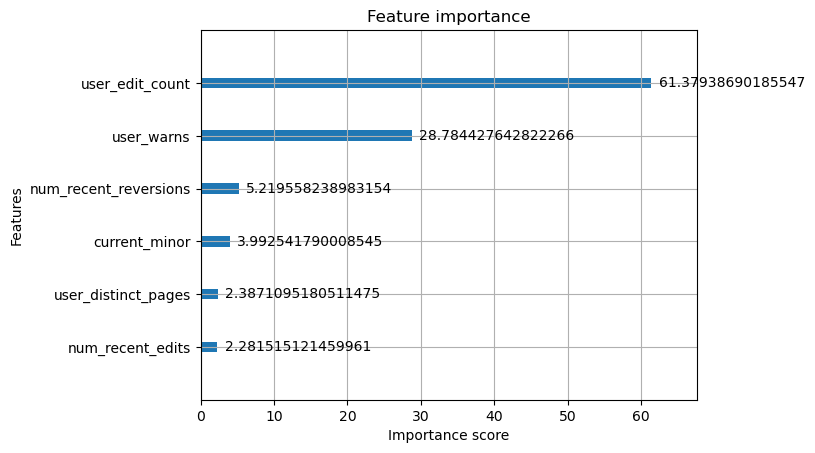

In [14]:
# Final Model with Best Hyperparameters
final_model = xgb.XGBClassifier(
    n_estimators = study.best_params["n_estimators"],
    max_depth = study.best_params["max_depth"],
    learning_rate = study.best_params["learning_rate"],
    eval_metric = "logloss",
    random_state = 42
)

final_model.fit(predictor, target)

xgb.plot_importance(final_model, importance_type = "gain")
plt.show()
